# **Step 1: `Reading and understanding the data`**

In [77]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV, KFold, cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.metrics import r2_score, mean_squared_error

- `SQLite` is a C library that provides a lightweight disk-based database that doesn’t require a separate server process and allows accessing the database using a nonstandard variant of the SQL query language. Some applications can use SQLite for internal data storage.

In [78]:
database = sqlite3.connect('database.sqlite')

In [79]:
data = pd.read_sql_query("SELECT * FROM Player_Attributes", database)

In [80]:
data.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


# **Step 2: `Data Description`**
- A story of what data is all about and the features present in the data
  ***About the Dataset***
    - The ultimate Soccer database for data analysis and machine learning
   - The dataset comes in the form of an SQL database and contains statistics of about 25,000 football matches, from the top football league of 11 European Countries. It covers seasons from 2008 to 2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations, with player names and a pair of coordinates to indicate their position on the pitch.
     - +25,000 matches
     - +10,000 players
     - 11 European Countries with their lead championship
     - Seasons 2008 to 2016
     - Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
     - Team line up with squad formation (X, Y coordinates)
     - Betting odds from up to 10 providers
     - Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches
  - The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video games. It is not just the stats that come with a new version of the game but also the weekly updates. So for instance if a player has performed poorly over a period of time and his stats get impacted in FIFA, you would normally see the same in the dataset.

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [82]:
data.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [83]:
data.shape

(183978, 42)

# **Step 3: `Handling Null values`**


In [84]:
data1 = data[['overall_rating','attacking_work_rate','crossing','heading_accuracy','vision','dribbling','sliding_tackle']].isnull().sum()/data.shape[0]*100

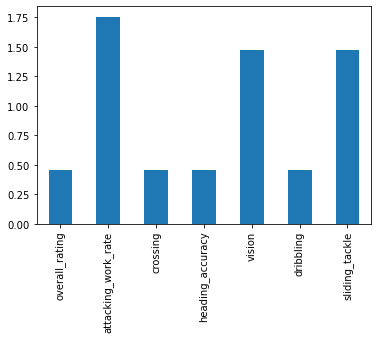

In [85]:
data1.plot.bar()
plt.show()

- Removing rows which contains Null Values in **Target** Column `(Overall Rating)`
- Target variable contains **836 null values**, its better to remove those.

In [86]:
data = data.dropna(axis=0 , subset=['overall_rating'])
data.shape  # Current dimensions of Dataset

(183142, 42)

In [87]:
print('Total null values present in the dataset: ',data.isnull().sum().sum())

Total null values present in the dataset:  15533


- Removing Null values from Other columns. There are some rows which contains `null values` in most number of columns, so its better to drop them.

- **Dropping all the rows contains Null values in 'volleys' columns** since most of the columns contains `null in same records`

In [88]:
data = data.dropna(axis=0, subset=['volleys'])  

In [89]:
data.isnull().sum()

id                       0
player_fifa_api_id       0
player_api_id            0
date                     0
overall_rating           0
potential                0
preferred_foot           0
attacking_work_rate    911
defensive_work_rate      0
crossing                 0
finishing                0
heading_accuracy         0
short_passing            0
volleys                  0
dribbling                0
curve                    0
free_kick_accuracy       0
long_passing             0
ball_control             0
acceleration             0
sprint_speed             0
agility                  0
reactions                0
balance                  0
shot_power               0
jumping                  0
stamina                  0
strength                 0
long_shots               0
aggression               0
interceptions            0
positioning              0
vision                   0
penalties                0
marking                  0
standing_tackle          0
sliding_tackle           0
g

- Let's handle null values in `attacking_work_rate` column

In [90]:
data['attacking_work_rate'].value_counts()

medium    125070
high       42823
low         8569
None        3317
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64

In [91]:
data['attacking_work_rate'].mode()[0]

'medium'

- as we can see mode of column `attacking_work_rate` is **median** category so we are going to replace all the null vaues with mode

In [92]:
# Imputing attacking_work_rate with mode i.e. 'Medium'
data.loc[ data['attacking_work_rate'].isnull() , 'attacking_work_rate' ] = data['attacking_work_rate'].mode()[0]

In [93]:
data.isnull().sum().sum()

0

**Total Missing values present now:  `0`**

In [94]:
data.shape

(181265, 42)

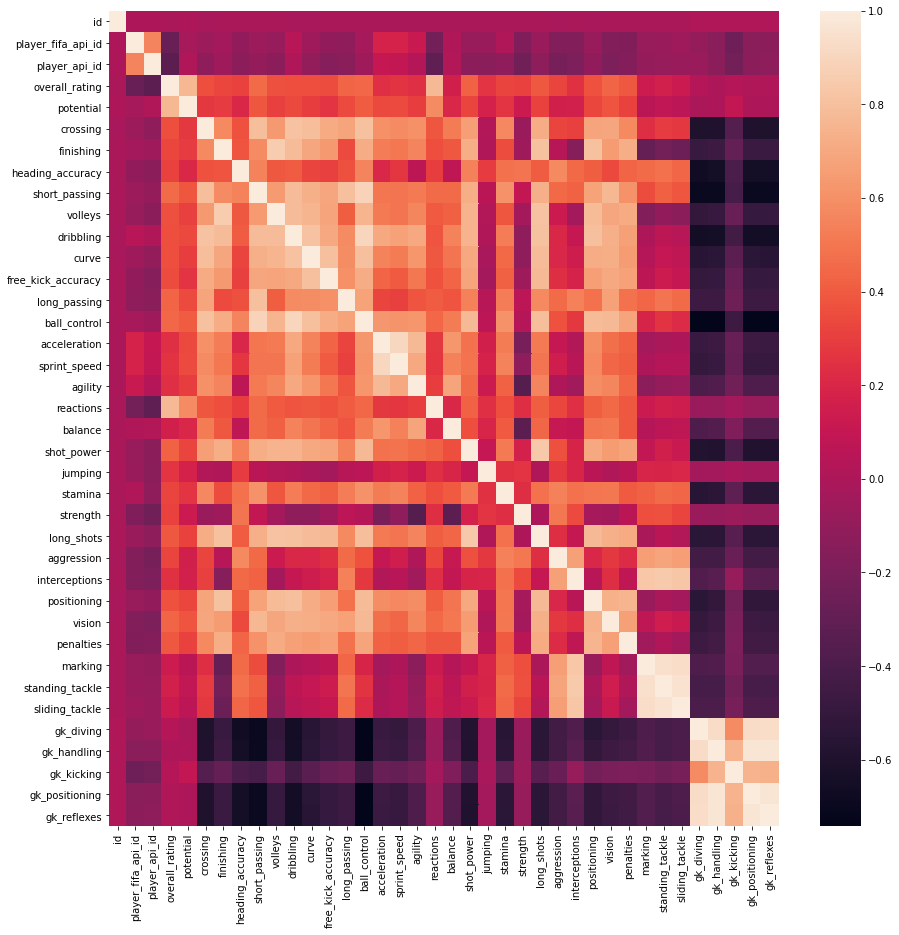

In [95]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr())
plt.show()

In [96]:
data = data.reset_index(drop=True)

- **Removing Redundant Features**
   - Since our main aim is to predict the overall rating of the players, based upon their performances in different aspects of athletics, We will remove, some unique features like is, `api_id` as well as `date`.


In [97]:
new_data = data.drop(columns=['id','player_fifa_api_id','player_api_id','date'], axis=1)
new_data.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [98]:
new_data.shape

(181265, 38)

# **Step 4: `Data Transformation and derivation of new attributes if necessary and statistical/graphical data analysis`**


- **Creating Dummy columns for Categorical Variable**
   - We have 3 categorical variable in the data set namely 
     - 1. `preferred_foot` : It consists of 2 category i.e. `Right` and `Left`. After encoding, right will be termed as 1 and left as 0. 
     - 2. `attacking_work_rate` and `defensive_work_rate` will create a new columns for each category in it.

In [99]:
cat_list = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

In [100]:
new_data['attacking_work_rate'].value_counts()

medium    125981
high       42823
low         8569
None        3317
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64

In [101]:
new_data['defensive_work_rate'].value_counts()

medium    130846
high       27041
low        18432
o           1328
_0           911
1            421
2            334
ormal        317
3            243
5            231
7            207
0            188
6            179
9            143
4            116
es            94
tocky         86
ean           78
8             70
Name: defensive_work_rate, dtype: int64

In [102]:
pd.crosstab(new_data['attacking_work_rate'], new_data['defensive_work_rate'])

defensive_work_rate,0,1,2,3,4,5,6,7,8,9,_0,ean,es,high,low,medium,o,ormal,tocky
attacking_work_rate,,,,,,,,,,,,,,,,,,,
None,168,377,245,220,89,203,145,193,65,126,0,0,0,69,7,82,1328,0,0
high,11,9,13,0,0,17,13,5,0,4,0,0,0,7939,5727,29085,0,0,0
le,0,0,0,0,0,0,0,0,0,0,0,78,0,0,0,0,0,0,0
low,0,0,0,12,18,0,0,0,0,0,0,0,0,3319,695,4525,0,0,0
medium,9,35,76,11,9,11,21,9,5,13,911,0,0,15714,12003,97154,0,0,0
norm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,317,0
stoc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86
y,0,0,0,0,0,0,0,0,0,0,0,0,94,0,0,0,0,0,0


- Assuming some mistakes while taking data, it is assumed that some of the cataegories from `attacking_work_rate` is present in the `defensive_work_rate` like
   - `stoc` - `tockey` --> **stockey** (a person who has short height but borad chest and shoulders)
   - `norm` - `ormal` --> **normal**
   - `le` - `ean` --> **lean**
   - `None` - `o` --> **None**

- **Changing Classes name in `attacking_work_rate`**

In [103]:
new_data['attacking_work_rate'].replace({'le':'lean','norm':'normal','stoc':'stocky','y':'yes'}, inplace=True)

- **Changing Classes name in `attacking_work_rate`**

In [104]:
new_data['defensive_work_rate'].replace({'ean':'lean','ormal':'normal','tocky':'stocky','es':'yes','o':'None','_0':'medium'}, inplace=True)

In [105]:
new_data['defensive_work_rate'].value_counts()

medium    131757
high       27041
low        18432
None        1328
1            421
2            334
normal       317
3            243
5            231
7            207
0            188
6            179
9            143
4            116
yes           94
stocky        86
lean          78
8             70
Name: defensive_work_rate, dtype: int64

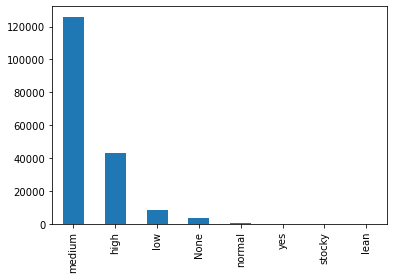

In [106]:
new_data['attacking_work_rate'].value_counts().plot.bar()
plt.show()

- **`defensive_work_rate` have numeric classes so we Imputing numeric classes as `None class`**

In [107]:
# Imputing numeric classes to None
new_data.loc[ new_data['defensive_work_rate'].isin(list('0123456789')) , 'defensive_work_rate' ] = 'None'

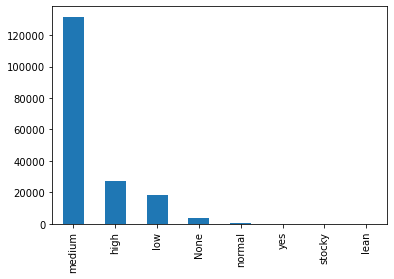

In [108]:
new_data['defensive_work_rate'].value_counts().plot.bar()
plt.show()

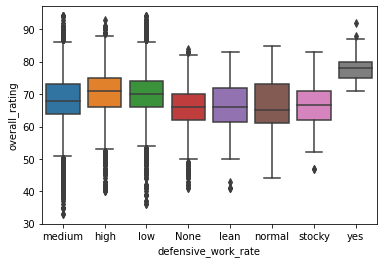

In [109]:
sns.boxplot(x = new_data['defensive_work_rate'],y = new_data['overall_rating'])
plt.show()

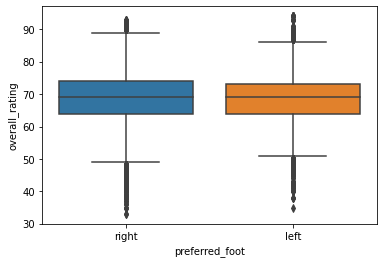

In [110]:
sns.boxplot(x = new_data['preferred_foot'],y = new_data['overall_rating'])
plt.show()

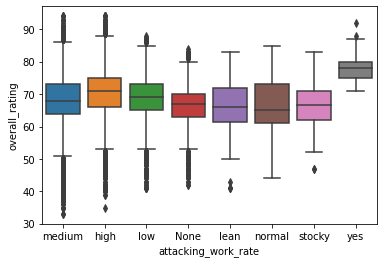

In [111]:
sns.boxplot(x = new_data['attacking_work_rate'],y = new_data['overall_rating'])
plt.show()

In [112]:
new_data.columns

Index(['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

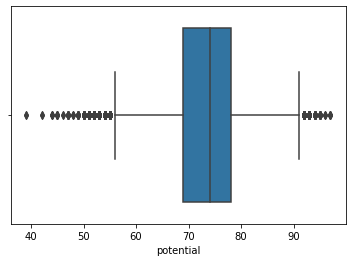

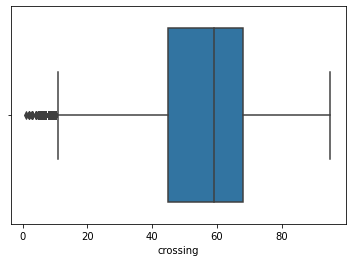

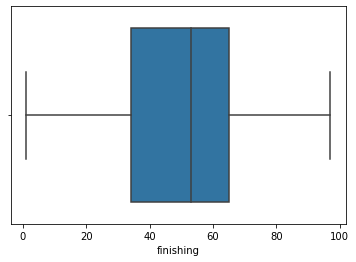

In [113]:
for i in ['potential','crossing','finishing']:
    sns.boxplot(new_data[i])
    plt.show()

- **take care of outliers**

In [114]:
for i in ['potential','crossing','finishing']:
    q1 = new_data[i].quantile(0.25)
    q3 = new_data[i].quantile(0.75)
    
    IQR = q3-q1
    UB = q3 + IQR*1.5
    LB = q1 - IQR*1.5
    
    new_data.loc[(new_data[i] < LB), i] = new_data[i].quantile(0.01)

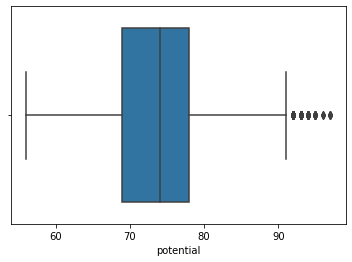

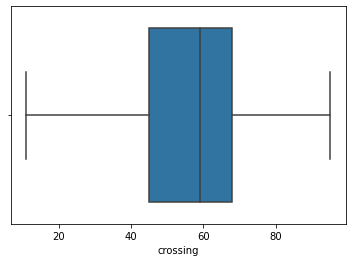

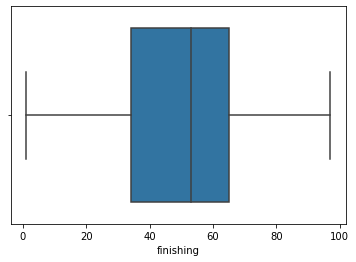

In [115]:
for i in ['potential','crossing','finishing']:
    sns.boxplot(new_data[i])
    plt.show()

### **creating dummy variables**

In [116]:
cat_list

['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

In [117]:
dummy_data = pd.get_dummies(new_data, columns = cat_list)
dummy_data.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,attacking_work_rate_stocky,attacking_work_rate_yes,defensive_work_rate_None,defensive_work_rate_high,defensive_work_rate_lean,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_normal,defensive_work_rate_stocky,defensive_work_rate_yes
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,0,0,0,0,0,0,1,0,0,0
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,0,0,0,0,0,0,1,0,0,0
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,0,0,0,0,0,0,1,0,0,0
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,0,0,0,0,0,0,1,0,0,0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,0,0,0,0,0,0,1,0,0,0


In [118]:
dummy_data.shape

(181265, 53)

In [119]:
dummy_data.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,attacking_work_rate_stocky,attacking_work_rate_yes,defensive_work_rate_None,defensive_work_rate_high,defensive_work_rate_lean,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_normal,defensive_work_rate_stocky,defensive_work_rate_yes
count,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,...,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000
mean,68.621493,73.488611,55.135713,49.939095,57.253871,62.459885,49.468436,59.230861,52.965675,49.380327,...,0.000474,0.000519,0.019088,0.149179,0.000430,0.101685,0.726875,0.001749,0.000474,0.000519
std,7.029845,6.533686,17.207646,19.047599,16.485767,14.186580,18.256618,17.749955,18.255788,17.824868,...,0.021777,0.022766,0.136835,0.356266,0.020739,0.302235,0.445566,0.041782,0.021777,0.022766
min,33.000000,56.000000,11.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,52.000000,41.000000,36.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,64.000000,56.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,72.000000,67.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
dummy_data.reset_index(drop=True, inplace=True)

- **separating x and y**

In [121]:
y = dummy_data['overall_rating']
x = dummy_data.drop(columns=['overall_rating'])

### Creating a Base model

In [122]:
x_lm = sm.add_constant(x)   # add a constant
lr = sm.OLS(y, x_lm).fit()  # build the model
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 2.169e+04
Date:                Sun, 28 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:51:33   Log-Likelihood:            -4.4265e+05
No. Observations:              181265   AIC:                         8.854e+05
Df Residuals:                  181219   BIC:                         8.859e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.1892      0.068    -32.391      0.000      -2.322      -2.057
potential                      0.3767      0.001    257.086      0.000       0.374       0.380
crossing                       0.0232      0.001     27.516      0.000       0.022       0.025
finishing                      0.0123      0.001     13.334      0.000       0.010       0.014
heading_accuracy               0.0689      0.001     84.496      0.000       0.067       0.070
short_passing                  0.0517      0.001     37.569      0.000       0.049       0.054
volleys                        0.0026      0.001      3.168      0.002       0.001       0.004
dribbling                     -0.0106      0.001     -9.119      0.000      -0.013      -0.008
curve                          0.0119      0.001     14.854      0.000       0.010       0.013
free_kick_accuracy             0.0129      0.001     18.223      0.000       0.012       0.014
long_passing                   0.0065      0.001      6.894      0.000       0.005       0.008
ball_control                   0.1345      0.002     85.011      0.000       0.131       0.138
acceleration                   0.0054      0.001      3.917      0.000       0.003       0.008
sprint_speed                   0.0112      0.001      8.589      0.000       0.009       0.014
agility                       -0.0083      0.001     -8.205      0.000      -0.010      -0.006
reactions                      0.2077      0.001    192.140      0.000       0.206       0.210
balance                        0.0070      0.001      8.983      0.000       0.005       0.009
shot_power                     0.0166      0.001     19.035      0.000       0.015       0.018
jumping                        0.0156      0.001     21.474      0.000       0.014       0.017
stamina                       -0.0029      0.001     -3.560      0.000      -0.005      -0.001
strength                       0.0597      0.001     71.343      0.000       0.058       0.061
long_shots                    -0.0138      0.001    -15.128      0.000      -0.016      -0.012
aggression                     0.0196      0.001     28.572      0.000       0.018       0.021
interceptions                  0.0122      0.001     16.620      0.000       0.011       0.014
positioning                   -0.0088      0.001    -11.192      0.000      -0.010      -0.007
vision                        -0.0024      0.001     -2.808      0.005      -0.004      -0.001
penalties                      0.0133      0.001     17.821      0.000       0.012       0.015
marking                        0.0322      0.001     28.742      0.000       0.030       0.034
standing_tackle                0.0039      0.001      2.993      0.003       0.001       0.006
sliding_tackle                -0.0272      

- As we can see that p-value of mostly all the categorical features are more than `0.05` and value of condition no. is around 10^16, which is showing high multicollinearity. Lets remove all these categorical features and their label encoding.

In [123]:
# Removing categorical features and their respective labels
new_x = x.iloc[:,:-16]

### **after removing features**

In [124]:
new_x_lm = sm.add_constant(new_x)
lr2 = sm.OLS(y, new_x_lm).fit()
lr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 2.736e+04
Date:                Sun, 28 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:51:44   Log-Likelihood:            -4.4413e+05
No. Observations:              181265   AIC:                         8.883e+05
Df Residuals:                  181229   BIC:                         8.887e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.5468      0.063    -40.315      0.000      -2.671      -2.423
potential                0.3790      0.001    256.885      0.000       0.376       0.382
crossing                 0.0225      0.001     26.475      0.000       0.021       0.024
finishing                0.0117      0.001     12.602      0.000       0.010       0.013
heading_accuracy         0.0699      0.001     85.195      0.000       0.068       0.072
short_passing            0.0506      0.001     36.574      0.000       0.048       0.053
volleys                  0.0038      0.001      4.539      0.000       0.002       0.005
dribbling               -0.0127      0.001    -10.857      0.000      -0.015      -0.010
curve                    0.0114      0.001     14.218      0.000       0.010       0.013
free_kick_accuracy       0.0128      0.001     17.915      0.000       0.011       0.014
long_passing             0.0067      0.001      7.126      0.000       0.005       0.009
ball_control             0.1363      0.002     85.599      0.000       0.133       0.139
acceleration             0.0059      0.001      4.273      0.000       0.003       0.009
sprint_speed             0.0095      0.001      7.249      0.000       0.007       0.012
agility                 -0.0083      0.001     -8.161      0.000      -0.010      -0.006
reactions                0.2098      0.001    192.682      0.000       0.208       0.212
balance                  0.0079      0.001     10.029      0.000       0.006       0.009
shot_power               0.0168      0.001     19.018      0.000       0.015       0.018
jumping                  0.0158      0.001     21.571      0.000       0.014       0.017
stamina                 -0.0050      0.001     -6.118      0.000      -0.007      -0.003
strength                 0.0619      0.001     73.498      0.000       0.060       0.064
long_shots              -0.0134      0.001    -14.595      0.000      -0.015      -0.012
aggression               0.0200      0.001     29.081      0.000       0.019       0.021
interceptions            0.0126      0.001     17.042      0.000       0.011       0.014
positioning             -0.0102      0.001    -12.901      0.000      -0.012      -0.009
vision                  -0.0027      0.001     -3.028      0.002      -0.004      -0.001
penalties                0.0142      0.001     18.931      0.000       0.013       0.016
marking                  0.0329      0.001     29.138      0.000       0.031       0.035
standing_tackle          0.0031      0.001      2.410      0.016       0.001       0.006
sliding_tackle          -0.0288      0.001    -26.030      0.000      -0.031      -0.027
gk_diving                0.1656      0.001    112.786      0.000       0.163       0.168
gk_handling              0.0331      0.002     17.147    

- Multicollineairy is **decreased from 10^16 to 4950**. Suggesting the categorical feature we removed have lower variance among them with higher correlation.

- All the features now have less than `0.05 p-value` suggesting all these features are statistically significant.

### Feature importance

In [125]:
best_feature = SelectKBest(score_func=chi2, k=10)
fit = best_feature.fit(new_x, y)

In [126]:
df_score = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(new_x.columns)

In [127]:
feature_score = pd.concat([df_columns,df_score], axis=1)
feature_score.columns = ["Features","Score"]

In [128]:
feature_score.sort_values(by = 'Score', ascending=False)


,Features,Score
20,long_shots,179272.528121
5,volleys,164229.099162
23,positioning,153053.332426
7,curve,149298.789192
2,finishing,145320.460249
8,free_kick_accuracy,144977.250480
16,shot_power,142979.536455
14,reactions,137520.610528
24,vision,136666.437264
10,ball_control,131525.842989


# ***Step 5: `Data Standardization and Normalization`***

In [129]:
old_scale_x = x.copy()
new_scale_x = new_x.copy()
def min_max_scale(col, scale_x):
    scale = MinMaxScaler()
    scale_x[col] = scale.fit_transform(scale_x[[col]])
    return scale_x

for col in old_scale_x.columns:
    old_scale_x = min_max_scale(col, old_scale_x)
    
for col in new_scale_x.columns:
    new_scale_x = min_max_scale(col, new_scale_x)

- **`old_scale_x`**:- **`with all the features`**
- **`new_scale_x`**:- **`without all the features`**

## **Cross Validation of Linear Regression Model**

- Cross validation `with all the features` including categorical

In [130]:
lr = LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
mse = cross_val_score(lr, old_scale_x, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(abs(mse))
np.mean(rmse), np.std(rmse)

(2.789950465623008, 0.011207944729066551)

- Cross validation `without categorical features`

In [131]:
lr = LinearRegression()
kf = KFold(n_splits= 5, shuffle = True)
mse = cross_val_score(lr, new_scale_x, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(abs(mse))
np.mean(rmse), np.std(rmse)

(2.8129869560017986, 0.01296327442624825)

- There is `very little to no. sign of overfitting`
- There is very limited effect of excluding categorical features. **Bias error is increased by 0.02** and **variance error decreases by 0.001**. This may be due to the fact that the columns we have excluded are having higher amount of multicollinearity.

# ***Step 6: `Model Training using ML Algorithm tested above`***

## **(a). Fitting a Base `Linear Regression` Model**

### LR model with all features

In [132]:
x_train, x_test, y_train, y_test = train_test_split(old_scale_x, y, test_size=0.2, random_state=42)

In [133]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print('Train R2_sq : ',r2_score(y_train, y_train_pred))
print('Test R2_Sq  : ',r2_score(y_test, y_test_pred))

print('Train RMSE  : ',mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE   : ',mean_squared_error(y_test, y_test_pred)**0.5)

Train R2_sq :  0.8434002392801642
Test R2_Sq  :  0.8434564308592389
Train RMSE  :  2.786091188117233
Test RMSE   :  2.7645181597823005


### LR model without categorical features

In [134]:
x_train, x_test, y_train, y_test = train_test_split(new_scale_x, y, test_size=0.2, random_state=42)

In [135]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print('Train R2_sq : ',r2_score(y_train, y_train_pred))
print('Test R2_sq  : ',r2_score(y_test, y_test_pred))

print('Train RMSE  : ',mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE   : ',mean_squared_error(y_test, y_test_pred)**0.5)

Train R2_sq :  0.840822115437255
Test R2_sq  :  0.8408897109725587
Train RMSE  :  2.8089314713340414
Test RMSE   :  2.787089811873565


- **R2_score** and **RMSE** of train and test data are `almost equal inferencing that the model is not overfit`.

## **Regularization**


### **1. `Lasso Regression`**
- LassoCV will return `best alpha` and `coeff`. after performing 10 CV

In [136]:
lasscv = LassoCV(alphas = None, cv = 10, max_iter = 1000, normalize = True)
lasscv.fit(x_train, y_train)

# best alpha parameter
alpha = lasscv.alpha_

- now that we have best parameter
- let's use lasso Regression and see how well our data had fitted before

In [137]:
lass_reg = Lasso(alpha)
lass_reg.fit(x_train, y_train)

# Checking Lasso Score

print("Score for train :  ",lass_reg.score(x_train, y_train))
print("Score for test  :  ",lass_reg.score(x_test, y_test))

Score for train :   0.8408220887007507
Score for test  :   0.8408899252477059


### **2. `Ridge Regression`**
- RidgeCV will return best `alpha` and `coeff`. after performing 10 CV
- We will pass an array of random numbers for ridgeCV to select best alpha from them

In [138]:
alpha = np.random.uniform(low = 0, high = 10, size = (50,))
ridgecv = RidgeCV(alphas = alpha, cv = 10 , normalize=True)
ridgecv.fit(x_train, y_train)

# best alpha parameter
alpha = ridgecv.alpha_

- now that we have best parameter
- let's use Ridge Regression and see how well our data had fitted before

In [139]:
ridge_reg = Ridge(alpha = alpha)
ridge_reg.fit(x_train, y_train)

# Checking Ridge Score

print("Score for train :  ",ridge_reg.score(x_train, y_train))
print("Score for test  :  ",ridge_reg.score(x_test, y_test))

Score for train :   0.8408221095465824
Score for test  :   0.8408898138480743


#### **Conclusion:-** 
- After using `Linear Regression` and `Regularization` the result is **not getting improve**, since the `already the model is very rightly fit`.

## **(b). `Decision Tree`** :

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [141]:
dtr = DecisionTreeRegressor(criterion='mse', random_state=0)         # estimator
dtr.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [145]:
x_test_pred = dtr.predict(x_test)
x_train_pred = dtr.predict(x_train)

print("Test Score  : ",r2_score(x_test_pred, y_test))
print("Train Score : ",r2_score(x_train_pred, y_train))

Test Score  :  0.9630732301250928
Train Score :  0.9993795144890845


### **Hyper-parameter tuning to achieve a better accuracy**

In [147]:
cv = ShuffleSplit(n_splits = 10, random_state = 42)        #cross validation

param_grid = {'max_depth': [3, 5, 7, 9, 13],
             'criterion': ['mse', 'friedman_mse']}

grid = GridSearchCV(dtr, param_grid = param_grid, cv = cv)

grid.fit(x_train, y_train)    #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=None, train_size=None),
             estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [3, 5, 7, 9, 13]})

In [148]:
grid.best_params_

{'criterion': 'friedman_mse', 'max_depth': 13}

In [149]:
grid.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=13, random_state=0)

In [150]:
new_dtr = DecisionTreeRegressor(criterion='friedman_mse', max_depth=13,
         random_state=0)
new_dtr.fit(x_train, y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=13, random_state=0)

In [151]:
print("DecisionTreeRegressor Score : ",new_dtr.score(x_test, y_test))

DecisionTreeRegressor Score :  0.9337927572749775


## **(c). `Random Forest`:**

In [152]:
rand_forest = RandomForestRegressor(random_state=123)
rand_forest.fit(x_train, y_train)

RandomForestRegressor(random_state=123)

In [153]:
x_test_pred = rand_forest.predict(x_test)
x_train_pred = rand_forest.predict(x_train)

print("Test Score  : ",r2_score(x_test_pred, y_test))
print("Train Score : ",r2_score(x_train_pred, y_train))

Test Score  :  0.9824391637931486
Train Score :  0.9971521233946284


### **Hyper-parameter tuning to achieve a better accuracy**

In [167]:
cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[9, 11, 13]}                 

grid = GridSearchCV(rand_forest, param_grid = param_grid, cv=cv)
grid.fit(x_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': [9, 11, 13],
                         'max_features': ['sqrt', 'log2', 10]})

In [168]:
grid.best_estimator_

RandomForestRegressor(max_depth=13, max_features=10, random_state=123)

In [169]:
new_rand_forest = RandomForestRegressor(max_depth=13, max_features=10, random_state=123)
new_rand_forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=13, max_features=10, random_state=123)

In [170]:
print("RandomForestRegressor Score:- ",new_rand_forest.score(x_test, y_test))

RandomForestRegressor Score:-  0.9653570606514186


## **(d). `Xgboost Regressor`:**

In [155]:
xgr = XGBRegressor(random_state = 42)
xgr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [156]:
x_test_pred = xgr.predict(x_test)
x_train_pred = xgr.predict(x_train)

print("Test Score  : ",r2_score(x_test_pred, y_test))
print("Train Score : ",r2_score(x_train_pred, y_train))

Test Score  :  0.9704588632916579
Train Score :  0.9758910419808559


### **Hyper-parameter tuning to achieve a better accuracy**

In [157]:
cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'max_depth': [5, 7],
              'learning_rate': [0.1, 0.3]}

grid = GridSearchCV(xgr, param_grid=param_grid, cv=cv, n_jobs= -1)
grid.fit(x_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=None, train_size=None),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate

In [164]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [165]:
new_xgr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
new_xgr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [166]:
print("XGBRegressor Score: ",new_xgr.score(x_test, y_test))

XGBRegressor Score:  0.9746457155035143


## **`Final Score With Hyperparameter Tuning`**

In [171]:
print("Decision Tree Regressor Score  : ",new_dtr.score(x_test, y_test))
print("Random Forest Regressor Score  : ",new_rand_forest.score(x_test, y_test))
print("XGB Regressor Score            : ",new_xgr.score(x_test, y_test))

Decision Tree Regressor Score  :  0.9337927572749775
Random Forest Regressor Score  :  0.9653570606514186
XGB Regressor Score            :  0.9746457155035143


#### **Conclusion:-**
- By accuracy comparision performed above we can say here that `XGB Regressor` gives better result than any other model. and it can predict the target function with approx `97% accuracy`.